In [1]:
## Sample Program
# Jeon, Seon Jin / 2023-12-25 on Christmas
# !pip install feast

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.inspection import permutation_importance

from datetime import datetime
import os
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
import boto3

# from feast import FeatureStore 


plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

warnings.filterwarnings('ignore')

In [3]:
auth_token = 'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPRE9SdWotcVYtcnNBbm9HM0loRmFJWlc3TndiQjJNWmE4UFBfMnZtcHpjIn0.eyJleHAiOjE3MDU1NzUxMzIsImlhdCI6MTcwNDk3MDMzMiwiYXV0aF90aW1lIjoxNzA0OTcwMzMyLCJqdGkiOiIyYzkwNGVhOC1hNjliLTQ1N2ItYTE1MC1iNDJiODY4NjFiMmMiLCJpc3MiOiJodHRwczovL2tleWNsb2FrLnVhLmV6bS5sb2NhbC9yZWFsbXMvVUEiLCJhdWQiOiJ1YSIsInN1YiI6ImM0Nzc5NDkwLWQ5NDUtNGRhYi1hODI5LTdhYTViZDU5N2RkNCIsInR5cCI6IklEIiwiYXpwIjoidWEiLCJub25jZSI6IlNZMHBqeFFaSUtESW5VQ1VpWkhNNGpEVVNoVVVKZ0JscmJ2akplMGNzVjAiLCJzZXNzaW9uX3N0YXRlIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwiYXRfaGFzaCI6IkwtY3dOZEV5WEc5VWhXRHBDSlFXaXciLCJhY3IiOiIxIiwic2lkIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwidWlkIjoiNjAwMiIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwiZ2lkIjoiNTAwNSIsIm5hbWUiOiJkZW1vIEFuUFMiLCJncm91cHMiOlsidWEtZW5hYmxlZCIsIm9mZmxpbmVfYWNjZXNzIiwiYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtdWEiXSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZGVtbyIsImdpdmVuX25hbWUiOiJkZW1vIiwicG9zaXhfdXNlcm5hbWUiOiJkZW1vIiwiZmFtaWx5X25hbWUiOiJBblBTIiwiZW1haWwiOiJkZW1vQGV6dWEuY29tIn0.Ekt_F1CnYtf78rs6_NgAlqXJyjMoZOqUf6nLwg929lB0dQ7xdpwK7I2UToaHoXS2z73U3ATWD3mGU0ZQ5dR4VChJCPjocN0gRQWWyw0AjHeKzbAhTCGVKgP26HqK1VHi10SBed_q5S_n8j47_QVRBXB6ANQ3UmbmnzMLR1mJH-zaH_jDF4rlfC8UB28sMVQm8lzKBRFCJrRCfkTpoStXZ7AwnXMzDcs4c4D7O3sRMxTC-iA2rT9sFioA4Z51-PwXjk-l0g6Qw8w846winmMhP84uyIgsd4g9jqn2ZYOH9Hkl7F-pS9GdqKaNodRVKWo0SknL4RpiMJxNckrxEbQOxg'

os.environ["AWS_ACCESS_KEY_ID"]      = auth_token 
os.environ["AWS_SECRET_ACCESS_KEY"]  = "s3"
os.environ["AWS_ENDPOINT_URL"]       = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'
os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'
os.environ["MLFLOW_S3_IGNORE_TLS"]   = "true"
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"

config = {
    "MINIO_HOST_URL": "http://minio-service.ezdata-system.svc.cluster.local:30000",
    "MINIO_ACCESS_KEY": auth_token,
    "MINIO_SECRET_KEY": "s3",
    "KSERVE_MODEL_NAME": "body-performance",
    "NAMESPACE": open("/var/run/secrets/kubernetes.io/serviceaccount/namespace", "r").read(),
    "BUCKET": "body-performance",
    "FILE_PATH": "dataset",
    "SERVICE_ACCOUNT": "kserve-minio-sa",
    "PROTOCOL_VERSION": "v2"
} 

features = [ 'age', 'gender', 'height', 'weight', 'body_fat', 'diastolic', 'systolic', 'grip_force', 'sit_bend_forward', 'sit_ups', 'broad_jump']

if os.path.exists("model_artifacts"):
    os.system("rm -rf model_artifacts")
os.mkdir("model_artifacts")


In [4]:
# mlflow set experiment
def set_experiment(exp_name):
    try:
        mlflow.set_experiment(exp_name)
    except Exception as e:
        raise RuntimeError(f"Failed to set the experiment: {e}")


# save train log into mlflow

def model_feature_importance(model, x_train):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=x_train.columns,
        columns=["Importance"])

    # sort by importance
    feature_importance.sort_values(
        by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(10, 4))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")

    # save image
    if not os.path.exists("model_artifacts"):
        os.mkdir("model_artifacts")
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')

def model_permutation_importance(model, x_train, x_val, y_val):
    p_importance = permutation_importance(
        model, x_val, y_val, random_state=42, n_jobs=-1)


    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=x_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(10, 4))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    if not os.path.exists("model_artifacts"):
        os.mkdir("model_artifacts")
    
    plt.savefig(
        "model_artifacts/permutation_importance.png", bbox_inches="tight")
    
def save_mlflow(model, features, hp_params, metrics):

    # log estimator_name name
    name = model.__class__.__name__
    mlflow.set_tag("estimator_name", name)

    # log input features
    mlflow.set_tag("features", str(features))

    mlflow.log_params({key: model.get_params()[key] for key in hp_params})
    mlflow.log_metrics({'F1_Score': metrics})

    # Save model to artifacts
    mlflow.sklearn.log_model(model, "model")
    mlflow.log_artifact("model_artifacts/permutation_importance.png", "importance")
    mlflow.log_artifact("model_artifacts/feature_importance.png", "importance")

    # log charts
    mlflow.log_params(model.get_params())
    # mlflow.end_run()

    
def get_mlframework(name):
    if name == 'XGBClassifier':
        m = 'xgboost'
    elif name == 'RandomForestClassifier':
        m = 'sklearn'
    elif name == 'AdaBoostClassifier':
        m = 'sklearn'
    else:
        m = 'sklearn'
    return m

    
    
def search_best_model(experiment_name):   

    query = "metrics.F1_Score > 0.5"
    best_run_df = mlflow.search_runs(
        filter_string=query,
        max_results=1,
        order_by=["metrics.F1_Score DESC"],
    )
    
    if len(best_run_df.index) == 0:
        raise Exception(f"Found no runs for experiment '{experiment_name}'")

    best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
    best_model_uri = f"{best_run.info.artifact_uri}/model"
    best_model = mlflow.sklearn.load_model(best_model_uri)

    #Print best run info
    print("Best run info:")
    # print(best_run)
    print(f"Run id: {best_run.info.run_id}")
    print(f"Run parameters: {best_run.data.params}")
    print(f"Run score: F1_Score = {best_run.data.metrics['F1_Score']:.4f}")
    print(f"Run model URI: {best_model_uri}")
    print(f"Model: {best_run.data.tags.get('estimator_name')}")
    ml_classifier = best_run.data.tags.get('estimator_name')
    return best_model, best_model_uri, get_mlframework(ml_classifier)
   

def init_minio_client():
    client = boto3.client(
        service_name="s3",
        aws_access_key_id=config.get("MINIO_ACCESS_KEY"),
        aws_secret_access_key=config.get("MINIO_SECRET_KEY"),
        endpoint_url=config.get("MINIO_HOST_URL"),
        verify=False)
    return client

def start_run(model_name):
    now = datetime.now()
    start_run = now.strftime("%d-%b, %H:%M")
    
    if mlflow.active_run():
        mlflow.end_run()
    mlflow.start_run(run_name= f"Train : {model_name}::{start_run}")


# Option1 : Load data From Object Storage


In [5]:
if os.path.exists("temp"):
    os.system("rm -rf temp")
os.mkdir("temp")

client = init_minio_client()
client.download_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/bodyPerfor_train.csv", Filename="temp/bodyPerfor_train.csv")
client.download_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/bodyPerfor_test.csv", Filename="temp/bodyPerfor_test.csv")

train = pd.read_csv('temp/bodyPerfor_train.csv')
test  = pd.read_csv('temp/bodyPerfor_test.csv')

# Option2 : Load data from Feast Store

In [6]:
# store = FeatureStore(repo_path='/mnt/shared/feast-store')
# train_cond = pd.read_parquet(path='./dataset/bodyPerfor_train.parquet')[['id','event_timestamp']]
# train_features = store.get_feature_service('bodytrain_fs')
# train = store.get_historical_features(
#     entity_df = train_cond,
#     features = train_features
# ).to_df()
# test_cond = pd.read_parquet(path='./dataset/bodyPerfor_test.parquet')[['id','event_timestamp']]
# test_features = store.get_feature_service('bodytest_fs')
# test = store.get_historical_features(
#     entity_df = test_cond,
#     features = test_features
# ).to_df()

In [7]:
train.head(2)

id  age gender  height  weight  body_fat  diastolic  systolic  \
0   920   40      M   173.8    73.2      12.0       80.0       148   
1  5998   35      M   176.2    73.7      15.7       64.0       119   

   grip_force  sit_bend_forward  sit_ups  broad_jump class  
0        46.9              15.0     50.0       250.0     A  
1        47.6              18.0     46.0       226.0     A

In [8]:
test.head(2)

id  age gender  height  weight  body_fat  diastolic  systolic  grip_force  \
0  11   42      M   169.2    65.4      19.3       63.0     110.0        43.5   
1  22   59      F   155.9    62.7      30.2       76.0     143.0        36.8   

   sit_bend_forward  sit_ups  broad_jump  
0              16.0     68.0         211  
1              29.1     25.0         122

## 데이터 전처리

In [9]:
# Train Data split into feature and label

xtrain = train.drop(columns ='class').copy()
ytrain = train[['class']].copy()

xtest = test.copy()

#3. EDA
xtrain.describe()

id           age        height        weight      body_fat  \
count  10713.000000  10713.000000  10713.000000  10713.000000  10713.000000   
mean    6705.064221     36.753664    168.554569     67.493615     23.240960   
std     3864.549752     13.607601      8.372870     11.916531      7.247821   
min        1.000000     21.000000    125.000000     26.300000      3.000000   
25%     3347.000000     25.000000    162.500000     58.200000     18.000000   
50%     6705.000000     32.000000    169.200000     67.500000     22.800000   
75%    10049.000000     48.000000    174.700000     75.400000     28.000000   
max    13393.000000     64.000000    193.800000    138.100000     78.400000   

          diastolic      systolic    grip_force  sit_bend_forward  \
count  10713.000000  10713.000000  10713.000000      10713.000000   
mean      78.846159    130.338654     37.002717         15.202553   
std       10.742433     14.652444     10.598279          8.572562   
min        0.000000      0.000000      0.000000        -25.000000   
25%       71.000000    120.000000     27.600000         10.900000   
50%       79.000000    130.000000     38.000000         16.200000   
75%       87.000000    141.000000     45.200000         20.800000   
max      156.200000    201.000000     70.400000        213.000000   

            sit_ups    broad_jump  
count  10713.000000  10713.000000  
mean      39.842024    190.273322  
std       14.258093     39.990996  
min        0.000000      0.000000  
25%       30.000000    162.000000  
50%       41.000000    194.000000  
75%       51.000000    222.000000  
max       80.000000    303.000000

In [10]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10713 entries, 0 to 10712
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10713 non-null  int64  
 1   age               10713 non-null  int64  
 2   gender            10713 non-null  object 
 3   height            10713 non-null  float64
 4   weight            10713 non-null  float64
 5   body_fat          10713 non-null  float64
 6   diastolic         10713 non-null  float64
 7   systolic          10713 non-null  int64  
 8   grip_force        10713 non-null  float64
 9   sit_bend_forward  10713 non-null  float64
 10  sit_ups           10713 non-null  float64
 11  broad_jump        10713 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 1004.5+ KB


In [11]:
#4. Check Null value

xtrain.isna().sum()

id                  0
age                 0
gender              0
height              0
weight              0
body_fat            0
diastolic           0
systolic            0
grip_force          0
sit_bend_forward    0
sit_ups             0
broad_jump          0
dtype: int64

In [12]:

#5. OneHotEncoding for gender

train_temp = pd.get_dummies(xtrain['gender'], drop_first=True)
train_temp = pd.concat([xtrain,train_temp], axis=1)
train_temp['gender'] = train_temp['M']
train_temp.drop(columns=['M'], inplace=True)
train_temp.head(5)


id  age  gender  height  weight  body_fat  diastolic  systolic  \
0    920   40       1   173.8    73.2      12.0       80.0       148   
1   5998   35       1   176.2    73.7      15.7       64.0       119   
2  11457   57       1   169.2    73.5      21.7       77.0       128   
3   2898   45       1   170.3    76.7      17.0       86.0       154   
4   3141   28       1   171.3    68.7      11.2       99.0       145   

   grip_force  sit_bend_forward  sit_ups  broad_jump  
0        46.9              15.0     50.0       250.0  
1        47.6              18.0     46.0       226.0  
2        49.5              14.8     39.0       206.0  
3        50.8              19.5     43.0       214.0  
4        42.7              23.2     71.0       269.0

In [13]:
test_temp = pd.get_dummies(xtest['gender'], drop_first=True)
test_temp = pd.concat([xtest,test_temp], axis=1)
test_temp['gender'] = test_temp['M']
test_temp.drop(columns=['M'], inplace=True)
test_temp.head(5)

id  age  gender  height  weight  body_fat  diastolic  systolic  grip_force  \
0  11   42       1   169.2    65.4      19.3       63.0     110.0        43.5   
1  22   59       0   155.9    62.7      30.2       76.0     143.0        36.8   
2  30   50       0   159.8    57.1      24.4       63.0     103.0        30.8   
3  49   28       1   180.1    82.1      15.0       83.0     147.0        52.6   
4  88   41       0   158.1    51.0      21.7       86.0     127.0        23.1   

   sit_bend_forward  sit_ups  broad_jump  
0              16.0     68.0         211  
1              29.1     25.0         122  
2              24.4     30.0         143  
3              18.8     55.0         247  
4              28.6     46.0         165

In [14]:
#6. 불필요한 컬럼 삭제

xtrain = train_temp[features].copy()
xtest  = test_temp[features].copy()
ytrain = ytrain['class'].copy()

In [15]:
#features = xtrain.columns.tolist()

In [16]:
#7. 전처리 Data Scaling

scale = StandardScaler().fit(xtrain)
xtrain_scale = scale.transform(xtrain)
xtest_scale = scale.transform(xtest)

In [17]:
# 라벨 A -> 0, B-> 1, C->2, D->3

ytrain = ytrain.map({'A':0,'B':1,'C':2,'D':3})

In [18]:
#8. 데이터 분할

x_train, x_val, y_train, y_val = train_test_split(xtrain_scale, ytrain, test_size=0.2, random_state=2024)
print(x_train.shape, x_val.shape)

# Hyperparameter
hp_params = {
    "n_estimators": 100,
}
hp_n_estimator = hp_params.get("n_estimators")
hp_max_depth = 8

x_train = pd.DataFrame(x_train, columns=features)
x_val = pd.DataFrame(x_val, columns=features)

# Set up an experiment with set_exp
experiment_name = "bodyPerformanceTest"

set_experiment(experiment_name)
print("experiment_name: ", experiment_name)


(8570, 11) (2143, 11)
experiment_name:  bodyPerformanceTest


## 모델 학습 및 평가

RandomForest F1 Score :  0.6775762635753267


Found credentials in environment variables.


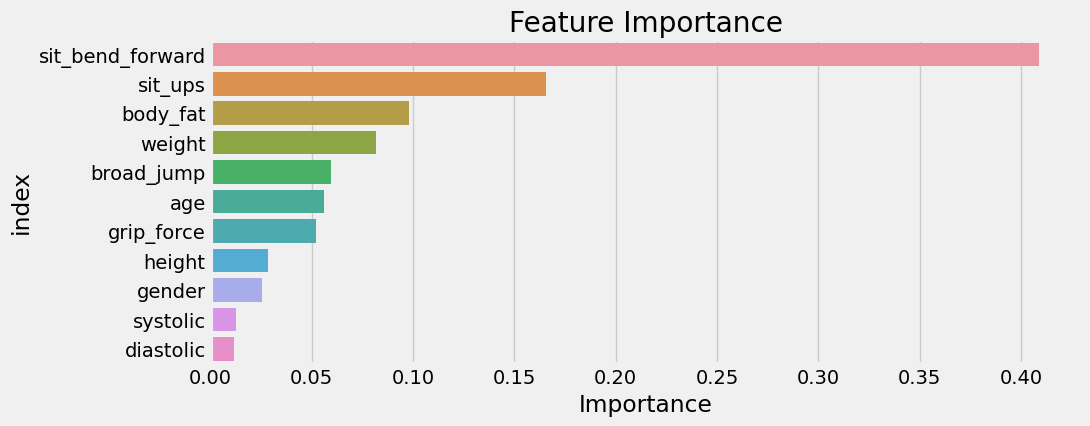

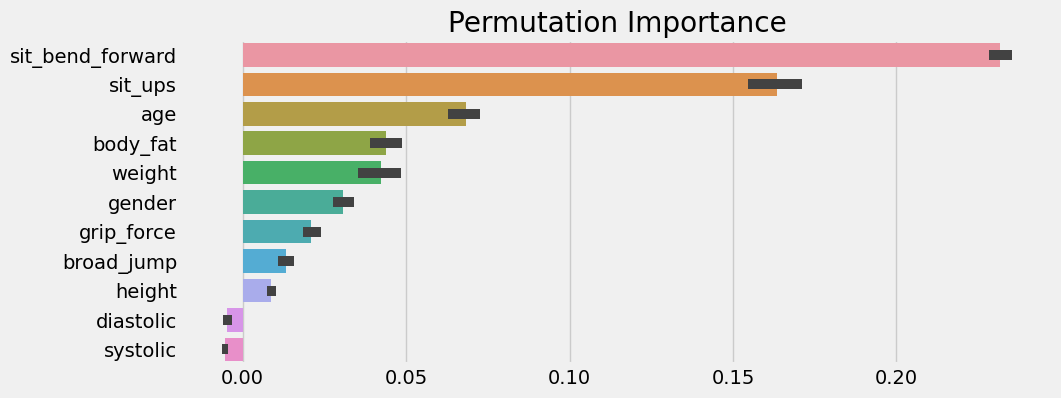

In [19]:
#9-1 RandomForest

start_run('RandomForest')
rf = RandomForestClassifier(max_depth = hp_max_depth, n_estimators=hp_n_estimator, random_state=2023)
model_rf = rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_val)

# evaluate f1 score
f1_rf = f1_score(y_val, pred_rf, average = 'macro')
print('RandomForest F1 Score : ', f1_rf)

# save model train to mlflow
model_feature_importance(model_rf,x_train)
model_permutation_importance(model_rf,x_train,x_val, y_val)
save_mlflow(model_rf, features, hp_params, f1_rf)

XGBoost F1 Score :  0.7433257969633005


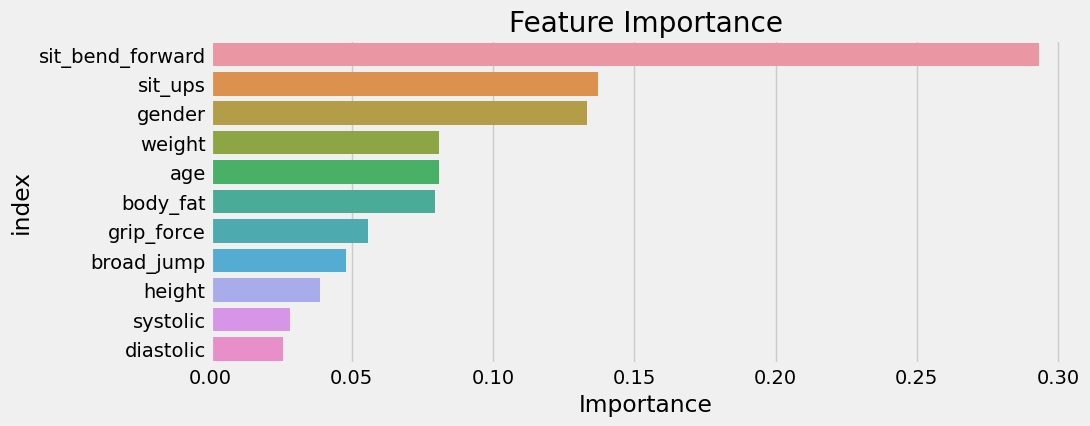

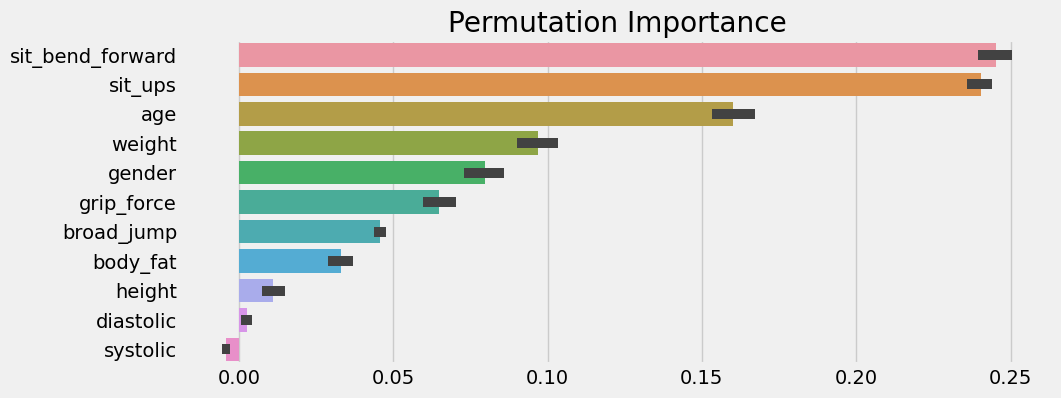

In [20]:
#9-2 XGBoost
start_run('XGBoost')
xgb = XGBClassifier(max_depth=hp_max_depth, n_estimators=hp_n_estimator, nthread=5,
                    min_child_weight=20, gamma=0.5, random_state=2023)
model_xgb = xgb.fit(x_train, y_train)
pred_xgb = model_xgb.predict(x_val)

# evaluate f1 score
f1_xgb = f1_score(y_val, pred_xgb, average = 'macro')
print('XGBoost F1 Score : ', f1_xgb)

# save model train to mlflow
model_feature_importance(model_xgb,x_train)
model_permutation_importance(model_xgb,x_train,x_val, y_val)
save_mlflow(model_xgb, features, hp_params, f1_xgb)

AdaBoost F1 Score :  0.5929020736414977


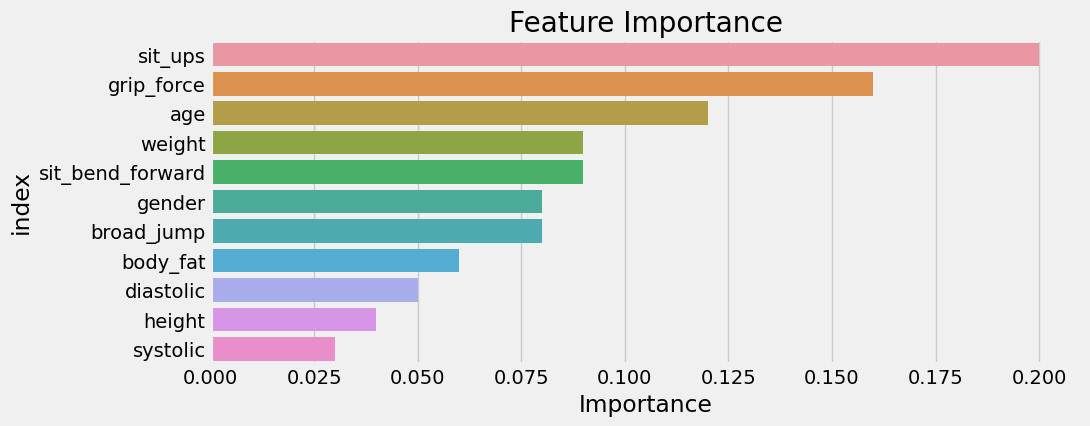

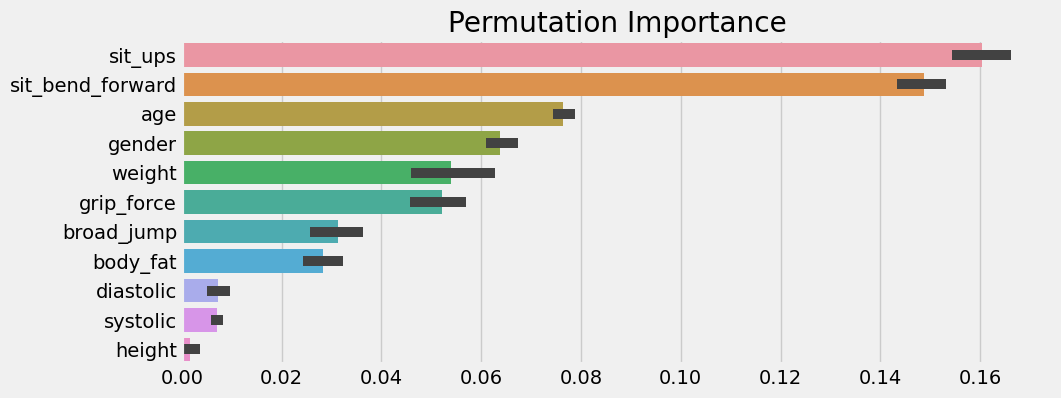

In [21]:
#9-3 AdaBoost
start_run('AdaBoost')
ada = AdaBoostClassifier(n_estimators=hp_n_estimator, random_state=2023)
model_ada = ada.fit(x_train, y_train)
pred_ada = model_ada.predict(x_val)

# evaluate f1 score
f1_ada = f1_score(y_val, pred_ada, average = 'macro')
print('AdaBoost F1 Score : ', f1_ada)

# save model train to mlflow
model_feature_importance(model_ada,x_train)
model_permutation_importance(model_ada,x_train,x_val, y_val)
save_mlflow(model_ada, features, hp_params, f1_ada)

## Save Predict result

In [48]:
best_model = model_rf

best_model_uri = "s3://mlflow/8/7e92b38420574d03bdad2dcd72ecf3f8/artifacts/model"
ml_framework = "sklearn"
print(f"Run model URI: {best_model_uri}")
print(f"ml_framework: {ml_framework}")


Run model URI: s3://mlflow/8/7e92b38420574d03bdad2dcd72ecf3f8/artifacts/model
ml_framework: sklearn


Best run info:
Run id: 017fdea820ce4380ad86516943229b76
Run parameters: {'n_estimators': '100', 'objective': 'multi:softprob', 'base_score': 'None', 'booster': 'None', 'callbacks': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'enable_categorical': 'False', 'eval_metric': 'None', 'feature_types': 'None', 'gamma': '0.5', 'grow_policy': 'None', 'importance_type': 'None', 'interaction_constraints': 'None', 'learning_rate': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': '8', 'max_leaves': 'None', 'min_child_weight': '20', 'missing': 'nan', 'monotone_constraints': 'None', 'multi_strategy': 'None', 'n_jobs': 'None', 'num_parallel_tree': 'None', 'random_state': '2023', 'reg_alpha': 'None', 'reg_lambda': 'None', 'sampling_method': 'None', 'scale_pos_weight': 'None', 'subsample': 'None', 'tree_method': 'None', 'validate_pa

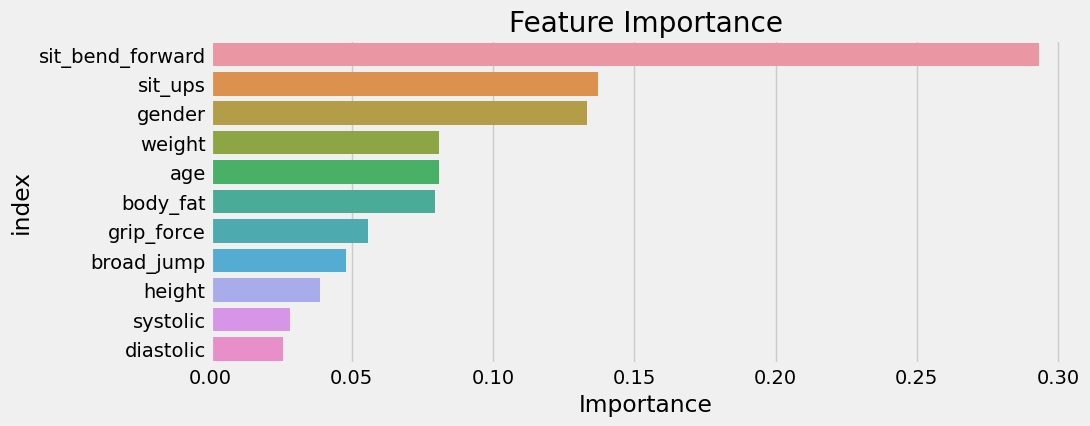

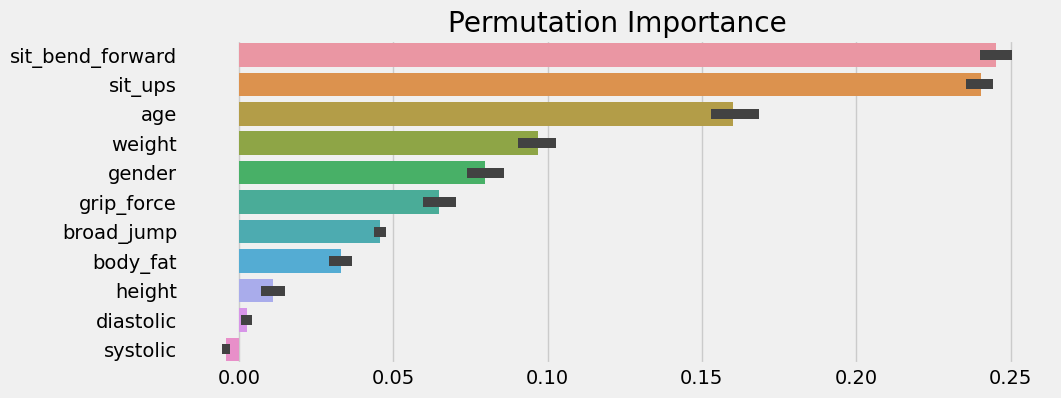

In [23]:
# best_model, best_model_uri, ml_framework = search_best_model(experiment_name)
# model_feature_importance(best_model,x_train)
# model_permutation_importance(best_model,x_train,x_val,y_val)

In [41]:

y_pred = best_model.predict(xtest_scale)
pred_dic = {'class': y_pred }
result = pd.DataFrame(pred_dic)
result['class'] = result['class'].map({0:'A',1:'B',2:'C',3:'D'})

if os.path.exists("temp"):
    os.system("rm -rf temp")
os.mkdir("temp")

result.to_csv("./temp/result.csv", index=False)
client = init_minio_client()
client.upload_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/result.csv",Filename="./temp/result.csv")
# client.upload_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/feature_importance.png",Filename="./model_artifacts/feature_importance.png")
# client.upload_file(Bucket=config.get("BUCKET"), Key=config.get("FILE_PATH")+"/permutation_importance.png",Filename="./model_artifacts/permutation_importance.png")

In [49]:
auth_token = 'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPRE9SdWotcVYtcnNBbm9HM0loRmFJWlc3TndiQjJNWmE4UFBfMnZtcHpjIn0.eyJleHAiOjE3MDU1NzUxMzIsImlhdCI6MTcwNDk3MDMzMiwiYXV0aF90aW1lIjoxNzA0OTcwMzMyLCJqdGkiOiIyYzkwNGVhOC1hNjliLTQ1N2ItYTE1MC1iNDJiODY4NjFiMmMiLCJpc3MiOiJodHRwczovL2tleWNsb2FrLnVhLmV6bS5sb2NhbC9yZWFsbXMvVUEiLCJhdWQiOiJ1YSIsInN1YiI6ImM0Nzc5NDkwLWQ5NDUtNGRhYi1hODI5LTdhYTViZDU5N2RkNCIsInR5cCI6IklEIiwiYXpwIjoidWEiLCJub25jZSI6IlNZMHBqeFFaSUtESW5VQ1VpWkhNNGpEVVNoVVVKZ0JscmJ2akplMGNzVjAiLCJzZXNzaW9uX3N0YXRlIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwiYXRfaGFzaCI6IkwtY3dOZEV5WEc5VWhXRHBDSlFXaXciLCJhY3IiOiIxIiwic2lkIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwidWlkIjoiNjAwMiIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwiZ2lkIjoiNTAwNSIsIm5hbWUiOiJkZW1vIEFuUFMiLCJncm91cHMiOlsidWEtZW5hYmxlZCIsIm9mZmxpbmVfYWNjZXNzIiwiYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtdWEiXSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZGVtbyIsImdpdmVuX25hbWUiOiJkZW1vIiwicG9zaXhfdXNlcm5hbWUiOiJkZW1vIiwiZmFtaWx5X25hbWUiOiJBblBTIiwiZW1haWwiOiJkZW1vQGV6dWEuY29tIn0.Ekt_F1CnYtf78rs6_NgAlqXJyjMoZOqUf6nLwg929lB0dQ7xdpwK7I2UToaHoXS2z73U3ATWD3mGU0ZQ5dR4VChJCPjocN0gRQWWyw0AjHeKzbAhTCGVKgP26HqK1VHi10SBed_q5S_n8j47_QVRBXB6ANQ3UmbmnzMLR1mJH-zaH_jDF4rlfC8UB28sMVQm8lzKBRFCJrRCfkTpoStXZ7AwnXMzDcs4c4D7O3sRMxTC-iA2rT9sFioA4Z51-PwXjk-l0g6Qw8w846winmMhP84uyIgsd4g9jqn2ZYOH9Hkl7F-pS9GdqKaNodRVKWo0SknL4RpiMJxNckrxEbQOxg'
os.environ["AWS_ACCESS_KEY_ID"]      = auth_token 
os.environ["AWS_SECRET_ACCESS_KEY"]  = "s3"
os.environ["AWS_ENDPOINT_URL"]       = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'

manifest = f"""
apiVersion: v1
kind: Secret
metadata:
  name: s3creds
  annotations:
     serving.kserve.io/s3-endpoint: {os.environ["AWS_ENDPOINT_URL"].replace("http://", "")}
     serving.kserve.io/s3-usehttps: "0"
     serving.kserve.io/s3-useanoncredential: "false"
     serving.kserve.io/s3-cabundle: ""
type: Opaque
stringData:
  AWS_ACCESS_KEY_ID: {os.environ["AWS_ACCESS_KEY_ID"]}
  AWS_SECRET_ACCESS_KEY: {os.environ["AWS_SECRET_ACCESS_KEY"]}

---
apiVersion: v1
kind: ServiceAccount
metadata:
  name: kserve-minio-sa
secrets:
- name: s3creds

---
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "body-performance"
spec:
  predictor:
     serviceAccountName: kserve-minio-sa
     model:
       modelFormat:
         name: {ml_framework}
       runtime: kserve-mlserver
       storageUri: "{best_model_uri}"
"""

os.makedirs("manifests", exist_ok=True)

with open(os.path.join("manifests", "isvc.yaml"), "w") as f:
    f.write(manifest)

In [52]:
DOMAIN_NAME = "svc.cluster.local"  # change this to your domain for external access
NAMESPACE = config.get("NAMESPACE")
DEPLOYMENT_NAME = config.get("KSERVE_MODEL_NAME")
MODEL_NAME = DEPLOYMENT_NAME
SVC = f'{DEPLOYMENT_NAME}-predictor-default.{NAMESPACE}.{DOMAIN_NAME}'
URL = f"https://{SVC}/v2/models/{MODEL_NAME}/infer"

print(URL)

https://body-performance-predictor-default.demo.svc.cluster.local/v2/models/body-performance/infer


In [53]:
res = subprocess.run(["kubectl", "apply", "-f", "manifests/isvc.yaml"])
print(res)

secret/s3creds configured
serviceaccount/kserve-minio-sa unchanged
inferenceservice.serving.kserve.io/body-performance configured
CompletedProcess(args=['kubectl', 'apply', '-f', 'manifests/isvc.yaml'], returncode=0)
